In [1]:
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(1234)

In [2]:
def exponential_rng(lam=1.0):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random number with rate lam.
    """
    return -np.log(np.random.rand()) / lam

In [3]:
def homogeneous_poisson_process(lam, T):
    arrivals = []
    t = exponential_rng(lam)
    while t <= T:
        arrivals.append(t)
        t += exponential_rng(lam)
    return arrivals

In [4]:
def totalRevenue(choices):
    
    revenueList = [0,1000,900,850,750,700,650,600,500,350]
    revenueList = np.flip(revenueList)
    revenue = 0
    for choice in choices:
        revenue += revenueList[choice]
        
    return revenue

In [5]:
def seatsSold(choices):
    return len(choices) - np.sum(np.array(choices) == 9)

In [6]:
lam_business = lambda t: 1.2*np.sin(t*np.pi/180.0)
lam_max_business = 1.2
lam_leisure = lambda t: 0.6*t/179
lam_max_leisure = 0.6
lam_economy = lambda t: 0.8*(1 + np.sin(t*np.pi/180.0 + np.pi))
lam_max_economy = 0.8

def non_homogeneous_poisson_process(lam_t, lam_max, T):
    arrivals = []
    t = exponential_rng(lam_max)
    while t <= T:
        if np.random.rand() < lam_t(t)/lam_max:
            arrivals.append(t)
        t += exponential_rng(lam_max)
    return arrivals

In [7]:
class Passenger:
    """ Generic event.
    
    Attributes:
        time (float): Event time.
        preferences (array): fare product preference weights.
    """
    
    def __init__(self, time):
        self.time = time
        self.preferences = np.zeros(10)
        
    def makeChoice(self,availabilities):
        
        probabilities = self.preferences*(availabilities > 0)
        probabilities = probabilities/np.sum(probabilities)
        
        cumsum = np.cumsum(probabilities)
        
        r = np.random.rand()
        
        choice = np.min(np.where(r < cumsum ))
        
        return choice
    
    def makeIdealChoice(self):
        
        probabilities = self.preferences
        probabilities = probabilities/np.sum(probabilities)
        
        cumsum = np.cumsum(probabilities)
        
        r = np.random.rand()
        
        choice = np.min(np.where(r < cumsum ))
        
        return choice
        
        
        
class Business(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([11, 15, 18, 20, 19, 15, 12, 11, 13, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)
        
class Leisure(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([8, 9, 11, 12, 14, 15, 16, 18, 20, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)
        
class Economy(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([1, 5, 8, 10, 11, 12, 13, 15, 20, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)

In [8]:
class Scenario:
    """ Road scenario
    
    Attributes:
        planning_horizon (int): days.
        t (int): early sales discount
        lam_business (float):
        lam_leisure (float):
        lam_economy (float):
    """
    
    def __init__(self, 
                 planning_horizon=180,
                 t=21,
                 lam_business=1.2,
                 lam_leisure=0.6,
                 lam_economy=0.8,
                 flag=0 # 1 if we want to offer 1 product at a time 
                ):
        self.planning_horizon = planning_horizon
        self.t = t
        self.lam_business = lam_business
        self.lam_leisure = lam_leisure
        self.lam_economy = lam_economy
        self.flag = flag

In [9]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
    """
    
    #Initialise the simulation
    t = 179
    events = []
    
    fare_offered = -1
    
    if scenario.flag:
        availabilities = np.zeros([10])
        fare_offered = 8 # The last element is "no purchase" so it is never offered
        availabilities[fare_offered] = 20 # Start from fare I and offer one at a time up to fare A
    else:
        availabilities = 20*np.ones([10]) # 9 fares + 1 NP
        
    
    
    availabilities[-1] = np.Inf # We can offer infinitely many non-purchases
    revenues = 0
    
    #Trigger the first events
    
    # Generate customer arrivals
    business_arrival_process = non_homogeneous_poisson_process(lam_business, lam_max_business, t)
    for i in business_arrival_process:
        events.append(Business(i))
    
    leisure_arrival_process = non_homogeneous_poisson_process(lam_leisure, lam_max_leisure, t)
    for i in leisure_arrival_process:
        events.append(Leisure(i))
    
    economy_arrival_process = non_homogeneous_poisson_process(lam_economy, lam_max_economy, t)
    for i in economy_arrival_process:
        events.append(Economy(i))
        
    events.sort(key=lambda event: event.time)
    
    '''
    termination = Termination(scenario.demand_duration)
    events = [generation, termination]
    '''
    choices = []
    idealChoices = []
    
    #Main loop
    while len(events):
        
        t = events[0].time
        
        e = events[0]
        
        choice = e.makeChoice(availabilities)
        choices.append(choice)
        
        idealChoice = e.makeIdealChoice()
        idealChoices.append(idealChoice)
        
        availabilities[choice] -= 1
        
        
        if scenario.flag:
            if availabilities[fare_offered] == 0 and fare_offered !=0:
                fare_offered -= 1
                availabilities[fare_offered] = 20
                
        if t < 21:
            availabilities[3] = 0
            availabilities[7] = 0
            
            if fare_offered == 3 or fare_offered == 7:
                fare_offered -= 1
                
                if scenario.flag:
                    availabilities[fare_offered] = 20
            
        
            
        events.pop(0)
    
        
    return choices, idealChoices

In [10]:
choices,idealChoices = simulate(Scenario(1))

print(choices)

[1, 8, 8, 8, 2, 8, 4, 1, 2, 8, 4, 5, 0, 2, 5, 5, 8, 1, 2, 5, 8, 4, 5, 2, 5, 6, 4, 9, 4, 8, 2, 5, 8, 0, 8, 4, 8, 8, 9, 4, 6, 6, 2, 2, 0, 0, 2, 4, 5, 8, 5, 9, 5, 6, 4, 9, 4, 6, 4, 4, 5, 0, 2, 6, 5, 8, 5, 2, 0, 5, 2, 4, 6, 1, 5, 0, 4, 4, 1, 4, 6, 1, 0, 4, 0, 5, 2, 5, 2, 2, 2, 8, 6, 0, 0, 8, 1, 8, 8, 9, 6, 5, 1, 0, 0, 2, 2, 0, 4, 6, 1, 0, 4, 6, 8, 9, 0, 1, 8, 4, 0, 6, 6, 5, 2, 0, 0, 5, 9, 0, 1, 6, 6, 1, 2, 6, 6, 9, 6, 9, 1, 6, 1, 1, 1, 9, 9, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [11]:
print(totalRevenue(choices))

95000


In [12]:
print(seatsSold(choices))

140


In [13]:
seats_available=180

In [14]:
print(idealChoices)

[8, 6, 5, 3, 2, 0, 7, 7, 1, 5, 0, 9, 3, 6, 4, 8, 8, 8, 2, 5, 5, 5, 2, 4, 9, 5, 7, 6, 4, 5, 3, 1, 6, 4, 8, 3, 2, 2, 2, 4, 7, 9, 6, 8, 5, 9, 3, 2, 4, 8, 3, 3, 0, 7, 2, 6, 4, 8, 1, 7, 5, 7, 6, 2, 6, 3, 3, 4, 2, 3, 4, 1, 4, 6, 2, 8, 1, 4, 1, 4, 6, 6, 3, 4, 1, 9, 1, 6, 8, 3, 3, 5, 9, 8, 7, 4, 8, 4, 1, 7, 5, 5, 6, 1, 4, 0, 8, 3, 6, 5, 1, 2, 8, 8, 0, 2, 2, 9, 8, 9, 7, 8, 3, 7, 7, 0, 8, 7, 2, 2, 8, 5, 4, 0, 7, 5, 5, 6, 3, 1, 5, 8, 0, 5, 7, 2, 3, 3, 4, 8, 3, 4, 5, 9, 4, 0, 7, 8, 0, 6, 7, 6, 2, 5, 7, 4, 8, 1, 9, 8, 8, 8, 7, 8, 5, 9, 3, 6, 4, 8, 6, 7, 8, 5, 9, 5, 5, 6, 1, 3, 6, 9, 5, 8, 8, 3, 4, 7, 3, 5, 7, 7, 8, 2, 1, 2, 7, 2, 3, 2, 3, 3, 3, 4, 7, 6, 0, 8, 3, 8, 8, 2, 4, 0, 6, 7, 3]


In [15]:
print(totalRevenue(idealChoices))

159300


In [16]:
print(len (idealChoices))

227


In [17]:
print(len (choices))

227


In [18]:
print (seatsSold(idealChoices))

214


In [19]:
def moving_mean_var(new_data, old_mean, old_var, t):
    if t == 1:
        new_mean = new_data
        new_var = 0
    else:
        new_mean = old_mean + (new_data - old_mean) / t
        new_var = (1 - 1 / (t - 1)) * old_var + t * (new_mean - old_mean)**2
    return new_mean, new_var

In [20]:
#simulate the process

precision = 0.1

revenue_mean = 0
revenue_var = 0
revenue_all = []
revenue_mean_all = []
revenue_var_all = []
t = 0

#main loop
while True:
    t+= 1
    
    #run simulation
    choices,idealChoices = simulate(Scenario(1))
    revenue = totalRevenue(idealChoices)
    print(revenue)
    
    #collect statistics
    revenue_mean, revenue_var = moving_mean_var(revenue, revenue_mean, revenue_var, t)
    revenue_all.append(revenue)
    revenue_mean_all.append(revenue_mean)
    revenue_var_all.append(revenue_var)
    
    #check if precision is reached
    if t >= 1000:
        break

173400
184550
185450
164350
180050
147900
174050
156150
176100
172100
176100
166700
182350
163050
187050
161650
172300
166500
175150
165100
175050
181600
175100
162850
158650
158400
166300
151250
169750
161800
161300
169400
155800
174500
181050
152350
151700
172050
174350
161250
137250
189200
161050
155750
168950
171150
172200
166900
159350
178950
140300
157050
158250
189550
160250
170200
163600
172600
157600
177800
151050
148600
176150
165100
172150
165650
173650
173800
174550
169600
148550
162750
187250
174800
157350
170450
163450
162000
180800
183550
159600
149950
166400
163600
171750
161950
158750
164650
171850
198600
164950
156750
158850
159400
161150
165000
154600
162750
173700
156700
182150
133000
160400
163750
148400
176100
191550
150800
158050
170100
149950
181150
155400
173250
178050
193050
164900
153600
177200
183300
167650
172850
162200
175400
155900
170250
180750
147450
194150
169550
163100
160200
165450
172400
173100
185100
176750
167400
151900
151500
158450
160350
166800

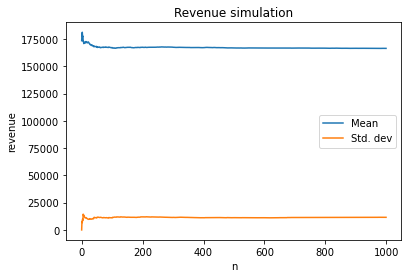

In [21]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(revenue_mean_all, label='Mean')
ax.plot(np.sqrt(revenue_var_all), label='Std. dev')
ax.set(title='Revenue simulation',
      xlabel = 'n',
      ylabel = 'revenue')
ax.legend()
plt.show()

In [45]:
def bootstrap(data, f_statistic, draws):
    theta = f_statistic(data)
    se = np.zeros((draws,))
    for d in np.arange(draws):
        data_draw = np.random.choice(data, size=data.shape[0], replace=True)
        theta_emp = f_statistic(data_draw)
        se[d] = (theta_emp - theta)**2
    mse = se.mean()
    return mse

In [46]:
revenue_all = np.array(revenue_all)
f_mean = lambda data: data.mean()
emp_mean = f_mean(revenue_all)
emp_mean

166347.9

In [47]:
mse_mean = revenue_all.var() / revenue_all.shape[0]
mse_mean

133130.79059

In [48]:
bootstrap_mean = bootstrap(revenue_all, f_mean, 1000)
bootstrap_mean

135516.91524250014

In [49]:
f_p95 = lambda data: np.quantile(data, q=0.95)
emp_p95 = f_p95(revenue_all)
emp_p95

184655.0

In [50]:
bootstrap_p95 = bootstrap(revenue_all, f_p95, 1000)
bootstrap_p95

440690.99999999884

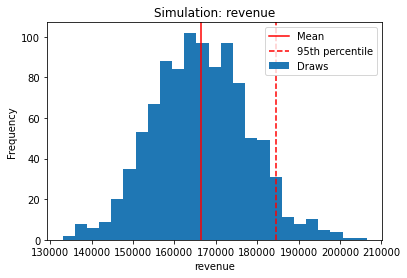

In [51]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

num_bins = 25
n, bins, patches = ax.hist(revenue_all, num_bins, density=0, label='Draws')
ax.axvline(emp_mean, label='Mean', color='r')
ax.axvline(emp_p95, label='95th percentile', color='r', linestyle='--')
ax.set(title='Simulation: revenue',
      xlabel='revenue',
      ylabel='Frequency')
ax.legend()
plt.show()